# Introduction

Welcome to the **Few Shot Object Detection for TensorFlow Lite** Colab. Here, we demonstrate fine tuning of a SSD architecture (pre-trained on COCO) on very few examples of a *novel* class. We will then generate a (downloadable) TensorFlow Lite model for on-device inference.

**NOTE:** This Colab is meant for the few-shot detection use-case. To train a model on a large dataset, please follow the [TF2 training](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_training_and_evaluation.md#training) documentation and then [convert](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md) the model to TensorFlow Lite.

# Set Up

## Imports

In [1]:
!python --version
!python -m pip show tensorflow

Python 3.8.0
Name: tensorflow
Version: 2.4.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /mnt/Data/git/duckietown/venv3.8/lib/python3.8/site-packages
Requires: tensorflow-estimator, wrapt, typing-extensions, termcolor, flatbuffers, google-pasta, grpcio, opt-einsum, six, absl-py, numpy, tensorboard, h5py, gast, wheel, keras-preprocessing, protobuf, astunparse
Required-by: tf-models-official


In [2]:
import matplotlib
import matplotlib.pyplot as plt

import os
import io
import imageio
import glob
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

tfds = tf.data.Dataset

from object_detection.utils import visualization_utils as viz_utils

import inspect
import sys
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
from exercise_ws.src.object_detection.include.object_detection.model import Wrapper
from exercise_ws.src.object_detection.include.object_detection.dataset import Dataset

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

%matplotlib inline

## Utilities

In [3]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    class_labels=True,
                    score_labels=True,
                    min_score_thresh=0.5):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=min_score_thresh,
      line_thickness=1,
      skip_scores=not score_labels,
      skip_labels=not class_labels)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Test .tflite model

## Load .tflite model

In [4]:
model = Wrapper(None)

Building model and restoring weights for fine-tuning...
INFO:tensorflow:Writing pipeline config file to ./pipeline.config
Weights restored!


## Generate prediction from each frame

In [7]:
test_image_dir = './test/originals'
gif_frames_dir = './test/frames'
test_images_np = []

dataset = Dataset()

for i in range(1, 100):
  image_path = os.path.join(test_image_dir, str(i) + '.npz')
  test_images_np.append(np.expand_dims(np.load(image_path)["arr_0"], axis=0))

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = model.predict(input_tensor)
  if i == 1:
    print(boxes, classes, scores)

  plot_detections(
      test_images_np[i][0],
      boxes,
      classes.astype(np.uint32) + dataset.label_id_offset,
      scores,
      dataset.category_index, 
      figsize=(15, 20), 
      image_name=gif_frames_dir + "/gif_frame_" + ('%02d' % i) + ".jpg",
      min_score_thresh=0.3
  )

Done prepping dataset.
[[0.2992285  0.20190716 0.4598772  0.30179077]
 [0.24799916 0.5427898  0.31301162 0.7035886 ]
 [0.25954056 0.81814355 0.30733633 0.9303253 ]
 [0.24778782 0.7963778  0.31180486 0.9812695 ]
 [0.26406774 0.85161394 0.30760124 0.9481414 ]
 [0.28641182 0.20491368 0.46128875 0.4283039 ]
 [0.27978316 0.6943188  0.30742022 0.71187377]
 [0.28077558 0.7204334  0.31109855 0.7401944 ]
 [0.29046035 0.3960148  0.36157227 0.43591183]
 [0.27925876 0.43420595 0.30923668 0.45715058]] [1. 3. 3. 3. 3. 2. 0. 0. 1. 0.] [0.767956   0.6856754  0.57399535 0.36555114 0.35729364 0.34162146
 0.33649212 0.290425   0.2877615  0.27342525]


## Assemble each processed frames into a GIF

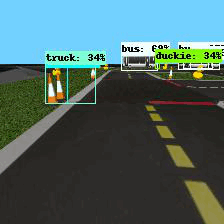

In [8]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob(gif_frames_dir + '/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))

# Check the dataset validity

## Process a batch of files

In [14]:
batch_size = 32
check_frames_dir = './check/frames'

dataset = Dataset()
ragged_batches = dataset.frames.apply(
  tf.data.experimental.dense_to_ragged_batch(batch_size=batch_size)
)

for batch in ragged_batches:
    images, gt_boxes, gt_classes = batch
    
    images_np = images.numpy().astype(np.uint8)
    boxes_np = gt_boxes.numpy()
    classes_np = gt_classes.numpy()

    # Decode one-hot encoding
    for i in range(classes_np.shape[0]):
        classes_np[i] = np.argmax(classes_np[i], axis=1)
    
    for i in range(batch_size):
        if boxes_np[i].shape[0] > 0:
          plot_detections(
            images_np[i],
            boxes_np[i],
            classes_np[i].astype(np.uint8) + label_id_offset,
            np.ones(boxes_np[i].shape[0]),
            dataset.category_index,
            figsize=(15, 20),
            image_name=check_frames_dir + "/gif_frame_" + ('%02d' % i) + ".jpg",
            class_labels=True,
            score_labels=False
          )
    break

Done prepping dataset.


## Assemble each processed frames into a GIF

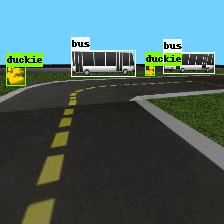

In [15]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_check_db.gif'

filenames = glob.glob(check_frames_dir + '/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=0.5)

display(IPyImage(open(anim_file, 'rb').read()))